# GEO1003 ~ Wi-Fi Fingerprinting

December 2023

Work by Tom Barbian (5100704), Der Derian Auliyaa Bainus (5941342), Corné Snoeij (5174473), Javier Martínez (6055613)

### Importing libraries

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Loading the data

##### Wi-Fi fingerprinting data

In [4]:
# load the files within folder /data/fingerprints into a list
wifi_path = os.getcwd() + '/data/fingerprints'
wifi_files = os.listdir(wifi_path)

# load the files into a list of dataframes
df_dict = {}

for file in wifi_files:
    try:
        df_dict[file] = pd.read_csv(wifi_path + '/' + file, sep='\t', header=0)
        df_dict[file].rename(columns={df_dict[file].columns[0]: "timestamp"}, inplace=True)
        df_dict[file].insert(0, 'room', file)

    except Exception as e:
        print(f"error reading file {file}: {e}")
        continue

error reading file .DS_Store: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


##### GNSS nmea data

In [5]:
# This function was coded by Lars, but modified to save to dataframe

def get_sat_values(filename):
    PDOP, HDOP, VDOP, latitude, longitude, num_used_satellites, altitude = [], [], [], [], [], [], []

    with open(filename, 'r') as file:
        lines = file.readlines()
        # divide messages
        messages = [lines[i:i + 7] for i in range(0, len(lines), 7)]

        for message in messages:
            PDOP.append(float(message[0].split(',')[15]))
            HDOP.append(float(message[0].split(',')[16]))
            VDOP.append(float(message[0].split(',')[17][:3]))
            latitude.append(float(message[6].split(',')[2:3][0]))
            longitude.append(float(message[6].split(',')[4:5][0]))
            num_used_satellites.append(int(message[6].split(',')[6]))
            altitude.append(float(message[6].split(',')[9:10][0]))

    # Create a DataFrame
    df = pd.DataFrame({
        'PDOP': PDOP,
        'HDOP': HDOP,
        'VDOP': VDOP,
        'latitude': latitude,
        'longitude': longitude,
        'num_used_satellites': num_used_satellites,
        'altitude': altitude
    })

    return df

##### Snapshot data

In [6]:
# load the files within folder /data/snapshots
snapshot_path = os.getcwd() + '/data/snapshots'
snapshot_files = os.listdir(snapshot_path)

# load the files into a list of dataframes
snapshot_dict = {}

for file in snapshot_files:
    try:
        snapshot_dict[file] = pd.read_csv(snapshot_path + '/' + file, sep='\t', header=0)
        snapshot_dict[file].rename(columns={snapshot_dict[file].columns[0]: "timestamp"}, inplace=True)
        snapshot_dict[file].insert(0, 'room', file)
    except Exception as e:
        print(f"error reading file {file}: {e}")
        continue

#### HEATPLOT

In [7]:
from scipy.spatial.distance import pdist, squareform

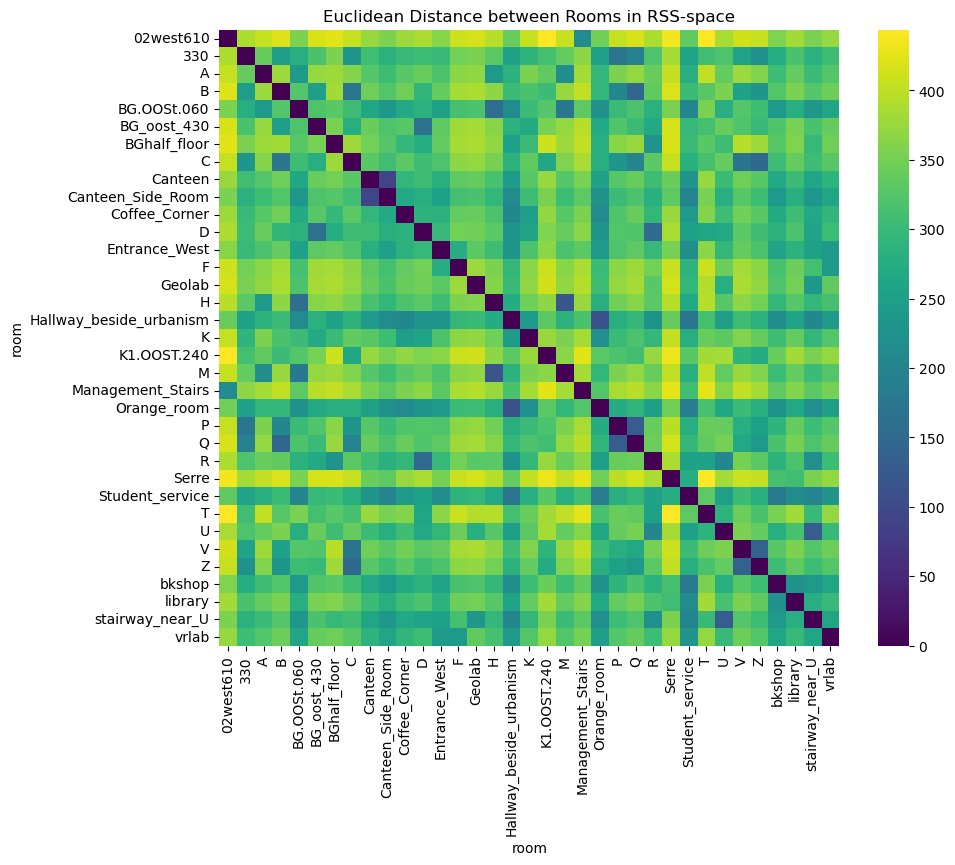

In [8]:
# Assuming df_dict is a dictionary where keys are room numbers and values are DataFrames
all_data = pd.concat([df.assign(room=room) for room, df in df_dict.items()])
# remove .txt in room column of all_data
all_data['room'] = all_data['room'].str.replace('.txt', '')

# Pivot the DataFrame
pivot_df = all_data.pivot_table(index='room', columns='MAC Address', values='Signal Strength', fill_value=-100) # -dBm as indication of weak signal

# Calculate Euclidean distances
distances = pdist(pivot_df.values, metric='euclidean')
distance_matrix = squareform(distances)

# Convert to a DataFrame for easier handling
distance_df = pd.DataFrame(distance_matrix, index=pivot_df.index, columns=pivot_df.index)

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', annot=False)
plt.title('Euclidean Distance between Rooms in RSS-space')
plt.savefig('Euclidean Distance between Rooms in RSS-space.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Get the 10 strongest signals for each room
df_dict['M.txt'].groupby(["MAC Address"]).agg({'room': 'first',
                                     'Signal Strength': 'mean'}).sort_values(by='Signal Strength', ascending=True)[:5].reset_index()

,MAC Address,room,Signal Strength
0,00:1E:42:4C:89:FC,M.txt,-90.937500
1,1C:28:AF:62:B8:B2,M.txt,-89.620690
2,D0:4D:C6:F2:F4:B1,M.txt,-89.552632
3,1C:28:AF:62:B8:B0,M.txt,-89.382353
4,D0:4D:C6:F2:F4:B2,M.txt,-89.011905


##### B. Localization Phase

Extend your Wi-Fi fingerprint exploration by measuring at four locations distinct from your radio
mapping data—specifically, locations measured by other groups (request their measurements).
Employ a 30-second snapshot, akin to phase A (15 minutes at least).

Now, leverage a pattern recognition matching algorithm, such as minimizing the sum of squares, to
identify the best fit among the 32 fingerprints corresponding to recognizable places.
- B1. Were you able to successfully pinpoint these four locations?
- B2. How confident are you in your findings?

In [10]:
def filter_top_mac_addresses(data_dict, n=5):
    """
    Filters each DataFrame in the provided dictionary to keep only rows with the top 5 MAC Addresses
    based on the best average signal strength.

    Parameters:
    data_dict (dict): A dictionary where keys are identifiers (like room names) and
                      values are DataFrames with columns 'room', 'MAC Address', and 'Signal Strength'.

    Returns:
    dict: A new dictionary with the same keys but filtered DataFrames.
    """
    filtered_dict = {}
    for key, value in data_dict.items():
        # Calculate the average signal strength for each MAC Address
        avg_signal_strength = value.groupby('MAC Address')['Signal Strength'].mean()

        # Sort and get top 5 MAC Addresses
        top_5_mac_addresses = avg_signal_strength.sort_values(ascending=False).head(n).index

        # Filter the DataFrame to keep only rows with these top 5 MAC Addresses
        filtered_df = value[value['MAC Address'].isin(top_5_mac_addresses)]

        # Store the filtered DataFrame in the new dictionary
        filtered_dict[key] = filtered_df[['room', 'MAC Address', 'Signal Strength']]

    return filtered_dict

In [11]:
# Function used for df_dict and snapshot_dict
df_dict_filtered = filter_top_mac_addresses(df_dict, 10)
snapshot_dict_filtered = filter_top_mac_addresses(snapshot_dict, 10)

# Pop 'Student_service.txt' and 'Orange_room.txt' from dictionary
df_dict_filtered.pop('Student_service.txt')
df_dict_filtered.pop('Orange_room.txt')

,room,MAC Address,Signal Strength
12,Orange_room.txt,1C:28:AF:66:4C:C0,-87
32,Orange_room.txt,1C:28:AF:66:2A:A0,-80
42,Orange_room.txt,1C:28:AF:65:FE:00,-72
43,Orange_room.txt,1C:28:AF:65:F5:C0,-71
44,Orange_room.txt,1C:28:AF:66:2A:B0,-71
...,...,...,...
7019,Orange_room.txt,1C:28:AF:66:28:00,-70
7020,Orange_room.txt,1C:28:AF:65:FE:00,-70
7021,Orange_room.txt,1C:28:AF:66:50:00,-69
7022,Orange_room.txt,1C:28:AF:66:2A:A0,-68


#### First pattern recognition algorithm
- B1. Were you able to successfully pinpoint these four locations?
- B2. How confident are you in your findings?

In [12]:
# Function to calculate the sum of squares difference
def sum_of_squares_difference(df1, df2):
    """
    Calculate the sum of squares difference between two dataframes based on signal strength of MAC addresses.

    Parameters:
    df1, df2 (DataFrame): DataFrames containing columns 'MAC Address' and 'Signal Strength'.

    Returns:
    float: Sum of squares difference.
    """
    # Merging the dataframes on 'MAC Address' and filling NaN values with -100 (weak signal assumption)
    merged_df = pd.merge(df1, df2, on='MAC Address', how='outer', suffixes=('_1', '_2')).fillna(-100)

    # Calculating sum of squares difference
    return ((merged_df['Signal Strength_1'] - merged_df['Signal Strength_2']) ** 2).sum()


# Function to find the best matching room for each snapshot
def find_top_three_matches(snapshot_dict, fingerprint_dict):
    results = {}
    for snapshot_key, snapshot_df in snapshot_dict.items():
        differences = []
        for fingerprint_key, fingerprint_df in fingerprint_dict.items():
            difference = sum_of_squares_difference(snapshot_df, fingerprint_df)
            differences.append((difference, fingerprint_key))

        # Sorting the list of tuples by the sum of squares difference
        top_three = sorted(differences)[:3]

        # Storing the top three matches in the results dictionary
        results[snapshot_key] = [(match[1], match[0]) for match in top_three]
    return results


# Finding the best match for each snapshot
top_three_matches = find_top_three_matches(snapshot_dict_filtered, df_dict_filtered)

# Displaying the results
for snapshot, matches in top_three_matches.items():
    print(f"Top three matches for {snapshot}:")
    for rank, (match, score) in enumerate(matches, start=1):
        print(f"  {rank}. {match} with score {score}")

Top three matches for library.txt:
  1. stairway_near_U.txt with score 1960120.0
  2. Serre.txt with score 2040696.0
  3. Hallway_beside_urbanism.txt with score 2046669.0
Top three matches for Geolab.txt:
  1. Geolab.txt with score 1227420.0
  2. stairway_near_U.txt with score 2027950.0
  3. Serre.txt with score 2108526.0
Top three matches for U.txt:
  1. stairway_near_U.txt with score 1934734.0
  2. Serre.txt with score 2015310.0
  3. Hallway_beside_urbanism.txt with score 2021283.0
Top three matches for B.txt:
  1. B.txt with score 1643706.0
  2. stairway_near_U.txt with score 1906723.0
  3. Serre.txt with score 1987299.0


#### Now use KNN

But first minimize the data as KNN is a distance based algorithm that is computationally expensive

In [13]:
# loop over dataframes in dictionary, groupby MAC Address, aggregate with mean, only keep top 5 MAC Addresses
def filter_top_mac_addresses(data_dict, n=5):
    filtered_dict = {}
    for key, value in data_dict.items():
        # Calculate the average signal strength for each MAC Address
        avg_signal_strength = value.groupby('MAC Address')['Signal Strength'].mean()

        # Sort and get top 5 MAC Addresses
        top_5_mac_addresses = avg_signal_strength.sort_values(ascending=False).head(n).index

        # Filter the DataFrame to keep only rows with these top 5 MAC Addresses
        filtered_df = value[value['MAC Address'].isin(top_5_mac_addresses)]

        # Store the filtered DataFrame in the new dictionary
        filtered_dict[key] = filtered_df[['room', 'MAC Address', 'Signal Strength']]

    return filtered_dict

In [16]:
dic = filter_top_mac_addresses(df_dict, 5)
dic['M.txt']

,room,MAC Address,Signal Strength
50,M.txt,D0:4D:C6:F2:C8:A2,-56
51,M.txt,D0:4D:C6:F2:C8:A1,-56
54,M.txt,D0:4D:C6:F2:C8:A0,-55
80,M.txt,D0:4D:C6:F2:C8:B1,-56
81,M.txt,D0:4D:C6:F2:C8:B0,-54
...,...,...,...
14845,M.txt,D0:4D:C6:F2:C8:A2,-51
14846,M.txt,D0:4D:C6:F2:C8:A1,-51
14849,M.txt,D0:4D:C6:F2:C8:A0,-51
14875,M.txt,D0:4D:C6:F2:C8:B1,-56
